- Data Augmentation Xception model (~0.7889): https://www.kaggle.com/faizunnabi/data-augmentation-xception-model-0-7889/code
- data_path: M:\dataset\Whale_Identification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # 数据可视化
import cv2
from keras.models import Sequential
from keras.layers import  Dense,Dropout
from keras.applications.xception import Xception
from keras.preprocessing.image import  ImageDataGenerator,img_to_array
from keras.applications.xception import preprocess_input
from sklearn.preprocessing import  LabelEncoder,OneHotEncoder
from keras.callbacks import  ReduceLROnPlateau

import datetime as dt

%matplotlib inline

Using TensorFlow backend.


In [3]:
data_path= "M:/dataset/Whale_Identification/train.csv"

whale_labels=pd.read_csv(data_path)

In [4]:
whale_labels.head()#.shape

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [5]:
top_populars=whale_labels.groupby("Id").count().sort_values(by="Image",ascending=False).reset_index().head(10)
print(top_populars)

          Id  Image
0  new_whale    810
1  w_1287fbc     34
2  w_98baff9     27
3  w_7554f44     26
4  w_1eafe46     23
5  w_fd1cb9d     22
6  w_ab4cae2     22
7  w_693c9ee     22
8  w_987a36f     21
9  w_43be268     21


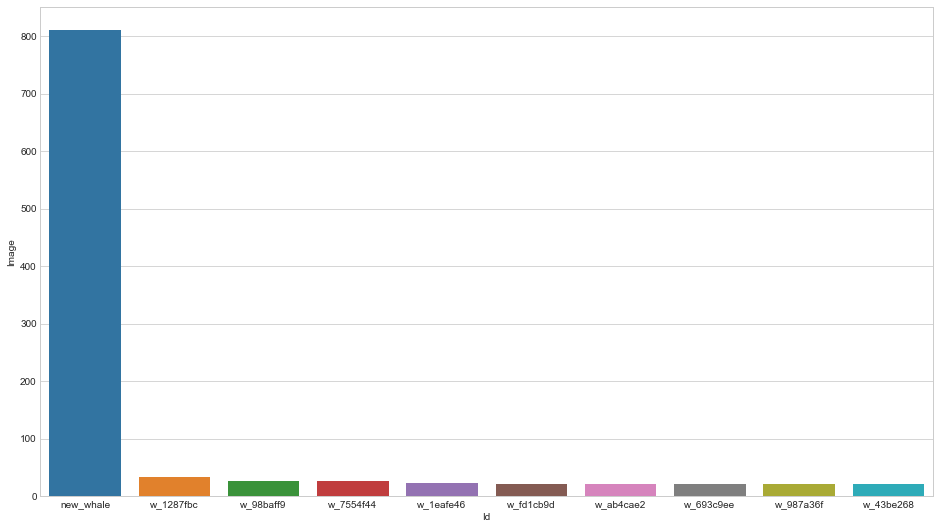

In [6]:
sns.set_style('whitegrid')
plt.figure(figsize=(16,9))
sns.barplot(x="Id",y="Image",data=top_populars)

In [7]:
top_populars.describe()

,Image
count,10.000000
mean,102.800000
std,248.516845
min,21.000000
25%,22.000000
50%,22.500000
75%,26.750000
max,810.000000


In [8]:
top_populars=whale_labels.groupby("Id").count().sort_values(by="Image",ascending=False).reset_index()
#print(top_populars)
print(top_populars.describe())
top_categories = list(top_populars['Id'].values)
#top_categories
#len(top_categories) # 4251

             Image
count  4251.000000
mean      2.317102
std      12.586066
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     810.000000


In [9]:
df = whale_labels[whale_labels["Id"].isin(top_categories)]
df

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3
5,0025e8c2.jpg,w_8b1ca89
6,0026a8ab.jpg,w_eaad6a8
7,0031c258.jpg,new_whale
8,0035632e.jpg,w_3d0bc7a
9,0037e7d3.jpg,w_50db782


In [10]:
cn = df.groupby('Id').count().reset_index()
cn

,Id,Image
0,new_whale,810
1,w_0013924,3
2,w_001ebbc,1
3,w_002222a,2
4,w_002b682,1
5,w_002dc11,1
6,w_0087fdd,2
7,w_008c602,1
8,w_009dc00,2
9,w_00b621b,2


In [11]:
width = 150
height = 150
channels = 3
batch_size = 16

base_model = Xception(include_top=False,input_shape=(width,height,3))

In [12]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 74, 74, 32)    864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 74, 74, 32)    128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 74, 74, 32)    0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [13]:
datagene=ImageDataGenerator(rotation_range=20,
                           width_shift_range=0.2,
                           height_shift_range=0.2,
                           zoom_range=0.2,
                           rescale=1./255,
                           horizontal_flip=True)

In [14]:
lbe=LabelEncoder()

y1=df["Id"].values

print(y1)
yl = lbe.fit_transform(y1)
print(y1)
onhe=OneHotEncoder()

yl = onhe.fit_transform(yl.reshape(-1,1))
print(y1)

['w_e15442c' 'w_1287fbc' 'w_da2efe0' ..., 'w_8b56cb1' 'w_2dcbf82'
 'w_b9bfd4e']
['w_e15442c' 'w_1287fbc' 'w_da2efe0' ..., 'w_8b56cb1' 'w_2dcbf82'
 'w_b9bfd4e']
['w_e15442c' 'w_1287fbc' 'w_da2efe0' ..., 'w_8b56cb1' 'w_2dcbf82'
 'w_b9bfd4e']


In [16]:
root= "M:/dataset/Whale_Identification/train/"

img_array = np.zeros(shape=(1028,width,width,3))
label_array = yl.toarray()
i=0
for index,row in df.iterrows():
    img = cv2.imread(root+row["Image"],0)
    img = cv2.resize(img,(150,150))
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    img = img_to_array(img)
    img_array[i] = img

In [17]:
img_array.shape
#img_array

(1028, 150, 150, 3)

In [18]:
train_f = datagene.flow(img_array,label_array,batch_size=batch_size)

ValueError: X (images tensor) and y (labels) should have the same length. Found: X.shape = (1028, 150, 150, 3), y.shape = (9850, 4251)